In [1]:
'''
TODO

Use string.punctuation
Include title and body in the final model corpus
and analyse that

most active user
per flair

average length per flair

no of posts per day

avg score per flair

highesst scored users

most popuar flair(in terms of score and posts)

same of the above for comments

posts with time

# most active time for each flair

most popular words per flair

'''

import numpy as np
import pandas as pd
import string
import re
import nltk
#nltk.download("stopwords")
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
plt.style.use("ggplot")
#sns.set()
plt.rcParams['figure.figsize'] = (16.0, 10.0)

df = pd.read_csv("data/data.csv")
df["body"] = df["body"].astype(str)

df.head()

,flair,title,score,id,url,comms_num,created,body,author,comments
0,AskIndia,"Lost my Job, Sick Mother and Paralysed Dad, In...",1044,g014wc,https://www.reddit.com/r/india/comments/g014wc...,130,1.586742e+09,Hi....It's really tough time for everyone. I r...,sanand_satwik,wrong
1,AskIndia,"Lost my Job, Sick Mother and Paralysed Dad, In...",1046,g014wc,https://www.reddit.com/r/india/comments/g014wc...,130,1.586742e+09,Hi....It's really tough time for everyone. I r...,sanand_satwik,you can check the subreddit r/forhire
2,AskIndia,Why does the government come with a begging bo...,651,fxofyu,https://www.reddit.com/r/india/comments/fxofyu...,205,1.586448e+09,"We have floods, terrorist attacks, famines due...",TWO-WHEELER-MAFIA,"Guys, I know it's sometimes easy to forget thi..."
3,AskIndia,Mother's condition is going worse due to hepat...,758,g0zlly,https://www.reddit.com/r/india/comments/g0zlly...,94,1.586871e+09,"Hi folks, I really appreciate the warm respons...",sanand_satwik,\+1\n\nAll my prayers for your mother. Hope sh...
4,AskIndia,Men who are 30+ and have decided not to get ma...,263,fvy95j,https://www.reddit.com/r/india/comments/fvy95j...,209,1.586207e+09,The corona virus has given me some time to thi...,indianoogler,"**“In my own bed, at the age of 80, with a be..."


In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2882 entries, 0 to 2881
Data columns (total 10 columns):
flair        2882 non-null object
title        2882 non-null object
score        2882 non-null int64
id           2882 non-null object
url          2882 non-null object
comms_num    2882 non-null int64
created      2882 non-null float64
body         2882 non-null object
author       2882 non-null object
comments     2716 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 225.3+ KB
None


First of all we check for any missing values:

In [3]:
df.isna().sum()

flair          0
title          0
score          0
id             0
url            0
comms_num      0
created        0
body           0
author         0
comments     166
dtype: int64

First of all, we'll start by converting the date to a standard format, from the timestammp of each post

In [4]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)

df["created"] = df["created"].apply(get_date)

**Plotting the amount of Data**

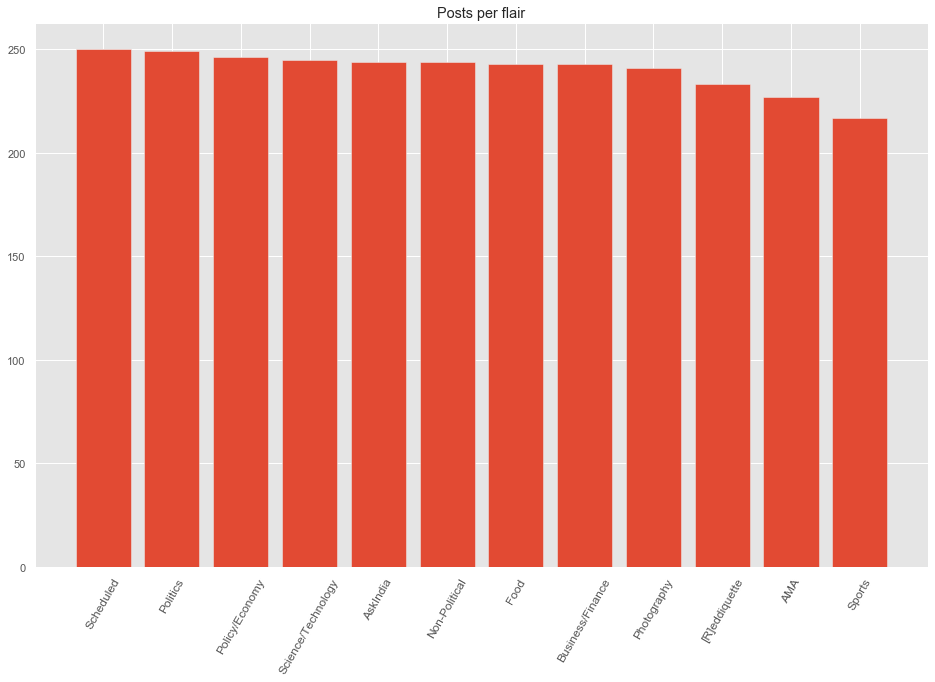

In [87]:
value_counts = df.flair.value_counts()

plt.bar(value_counts.index, value_counts)
plt.title("Posts per flair")
plt.xticks(rotation = 60, fontsize = 12)
plt.show()

From here, we observe that we have around 220 to 250 posts per flair, so this means that the dataset is somewhat balanced, and during final modelling, the model won't bias towards other flairs because of less data for some particular flair

# Preliminary Text Analysis of the posts

Finally, we have all the data about the posts that we need for our next part, which is the analysis. We will do the following:

    lowercasing
    word count
    Average word length

We will do these for each of the posts and create a new column for each of these values for their corresponding columns.

In [88]:
# Lowercasing

df["title"] = df["title"].apply(lambda x: x.lower())
df["body"] = df["body"].apply(lambda x: x.lower())

In [89]:
#Firstly we will do some exploration of the text

# 1. Counting the number of words in each post
df['word_count_body'] = df['body'].apply(lambda x: len(str(x).split(" ")))
#df['word_count'].describe()
df['word_count_title'] = df['title'].apply(lambda x: len(str(x).split(" ")))
df['word_count_title'].describe()


# Average Word Length
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

df['avg_wlen_body'] = df['body'].apply(lambda x: avg_word(x))
df['avg_wlen_title'] = df['title'].apply(lambda x: avg_word(x))

Now, plotting the word count in a density plot:

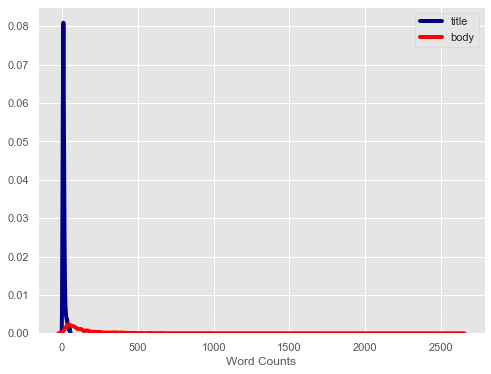

In [90]:
plt.figure(figsize = (8, 6))

sns.distplot(df['word_count_title'], hist=False, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label = "title")

sns.distplot(df['word_count_body'], hist=False, kde=True, color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label = "body")
plt.xlabel("Word Counts")
plt.legend()
plt.show()

C:\Users\azfar\Anaconda3\envs\atneva2\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


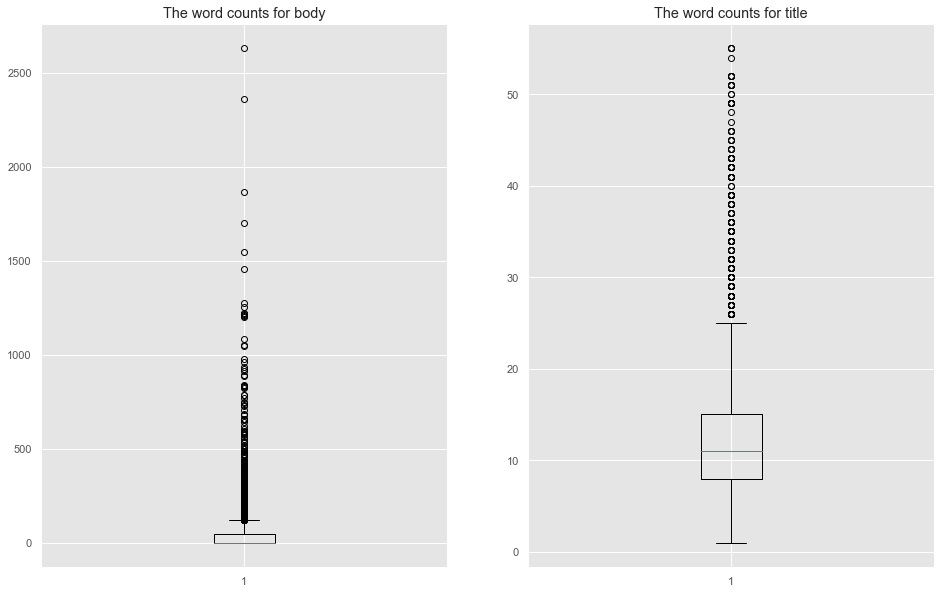

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.boxplot(df['word_count_body'])
ax1.set_title("The word counts for body")

ax2.boxplot(df['word_count_title'])
ax2.set_title("The word counts for title")

fig.show()

These density and boxplots show us that most of the posts have word counts below 1000 and most titles have length ranging 8 to 15 words

**The average number of words per flair**

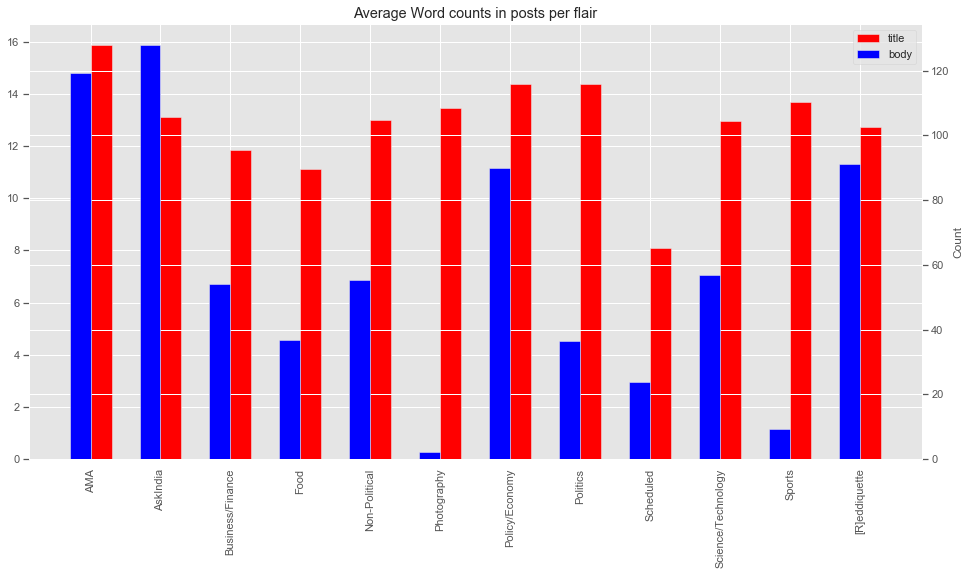

In [92]:
avgs = df.groupby("flair").mean()

title_word = avgs["word_count_title"]
body_word = avgs["word_count_body"]

plt.figure(figsize = (16, 8))
ax1 = plt.subplot(1, 1, 1)
x = np.arange(12)
w = 0.3
plt.xticks(x, avgs.index, rotation='vertical')
title = ax1.bar(x + w/2, title_word, w,color = "red", align = "center")
ax2 = ax1.twinx()
body = ax2.bar(x - w/2, body_word, w, color = "blue", align = "center")
plt.title("Average Word counts in posts per flair")
plt.ylabel("Count")
plt.legend([title, body], ["title", "body"])
plt.show()

From this we get a very important insight into the data, that posts with flairs "Photography" and "Sports" don't have much of matter written in the body. Which means, people who like to submit posts like this are more fond of sharing pictures rather than sharing written experiences.

**Doing the same for average word length**

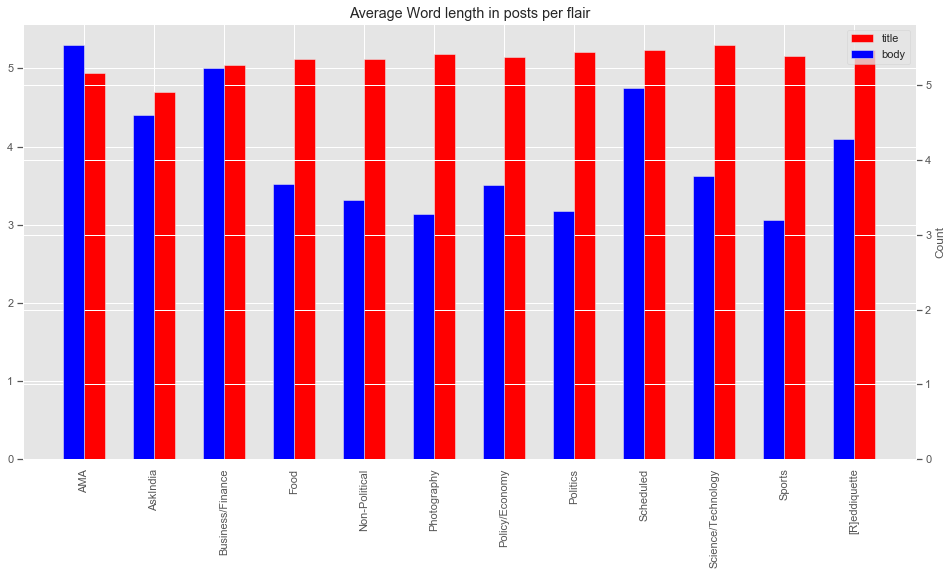

In [93]:
#Average word length

avgs = df.groupby("flair").mean()

title_word = avgs["avg_wlen_title"]
body_word = avgs["avg_wlen_body"]

plt.figure(figsize = (16, 8))
ax1 = plt.subplot(1, 1, 1)
x = np.arange(12)
w = 0.3
plt.xticks(x, avgs.index, rotation='vertical')
title = ax1.bar(x + w/2, title_word, w,color = "red", align = "center")
ax2 = ax1.twinx()
body = ax2.bar(x - w/2, body_word, w, color = "blue", align = "center")
plt.title("Average Word length in posts per flair")
plt.ylabel("Count")
plt.legend([title, body], ["title", "body"])
plt.show()


# Text Pre-processing

Next we will apply the following operations on this dataframe.

    Stopword removal
    Punctuation and Emoji Removal
    Lowercasing


For the purpose of modeling, we will use both, the title and the body of the posts ast the final corpus to feed into the data.
So, first we'll begin by merging the 2 columns

In [94]:
df["corpus"] = df["title"] + df["body"]

In [95]:
# Removing emojis

def rem_emoji(text):
    '''
    Takes a string as an input and returns the 
    same string after removing all the emojis
    '''
    
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    
    return(emoji_pattern.sub(r'', text)) # no emoji

df["corpus"] = df["corpus"].apply(rem_emoji)

**Identifying the stopwords and the rare words**
Stopwords are the most common words that occur, but before that, we will first remove the most common stopwords, of the english language, that cause noise in the text. For eg.- is, am, are, etc.

In [96]:
# Importing the list of all stopwords
english_stopwords = set(stopwords.words("english"))

#Stop word removal
df['corpus'] = df['corpus'].apply(lambda x: ' '.join([x for x in x.lower().split() if x not in english_stopwords]))
df["corpus"][0]

"lost job, sick mother paralysed dad, lockdown earn online?hi....it's really tough time everyone. recently lost job. mom lever patient. money saved already spent mother's treatment. tell earn money online? money actually right suggest way get paid asap. thanks reading! update: asking qualifications skills. engineering graduate, experience wordpress customization, logo design content writing. apart these, video editing knowledge well. please suggest accordingly. previously worked company data annotation work ai( company lost project, subsequently lost job). currently, learning web technologies like php, js."

In [97]:
# Punctuation Removal
df['corpus'] = df['corpus'].str.replace('[^\w\s]',' ')
    
print("This is how a post looks like now:\n", df["corpus"][0])

This is how a post looks like now:
 lost job  sick mother paralysed dad  lockdown earn online hi    it s really tough time everyone  recently lost job  mom lever patient  money saved already spent mother s treatment  tell earn money online  money actually right suggest way get paid asap  thanks reading  update  asking qualifications skills  engineering graduate  experience wordpress customization  logo design content writing  apart these  video editing knowledge well  please suggest accordingly  previously worked company data annotation work ai  company lost project  subsequently lost job   currently  learning web technologies like php  js 


Now Again we check, what words are the most occuring in the resultant cleaned text

In [98]:
stop_words = pd.Series(' '.join(df['corpus']).split()).value_counts()[:20]
print("The top 10 stop words(most common words) are:\n", stop_words)

The top 10 stop words(most common words) are:
 india     1466
i         1307
s         1228
https     1202
com       1104
www        755
people     603
like       545
nan        544
m          540
indian     515
bot        513
also       408
one        402
r          376
it         374
get        365
a          357
would      348
time       343
dtype: int64


To reduce the risk of any noise, we remove these too

In [99]:
df['corpus']=df['corpus'].apply(lambda x: ' '.join([x for x in x.split() if x not in stop_words]))

Now checking again, it looks fine

In [100]:
stop_words = pd.Series(' '.join(df['corpus']).split()).value_counts()[:20]
print("The top 10 stop words(most common words) are:\n", stop_words)

The top 10 stop words(most common words) are:
 thread        342
2             341
us            332
know          330
even          329
hotstar       329
problem       322
in            318
discussion    300
reddit        299
government    284
my            283
if            282
questions     277
am            274
1             272
random        272
any           269
want          265
ask           260
dtype: int64


# Advanced Visualization

Now well be doing some more advanced processing work with the posts, like:

    N-grams

Visualizing the top 15 N-grams(Only Uni-grams, Bi-grams and Tri-grams)

We will visualize them using barplots with the help of Python's seaborn library.

**Uni-grams**

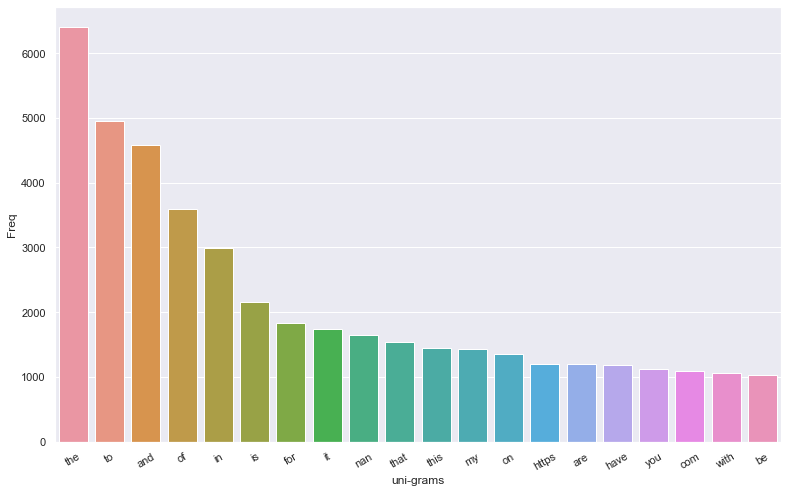

In [101]:
from sklearn.feature_extraction.text import CountVectorizer
import re
#Most frequently occuring words
arr=list(df['body'])

def get_top_n_words(arr, n=None):
    vec = CountVectorizer().fit(arr)
    bag_of_words = vec.transform(arr)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
  
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(arr, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["uni-grams", "Freq"]
#print(top_df)

#Now visualizing the barplot
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="uni-grams", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show()

**Bi-grams**

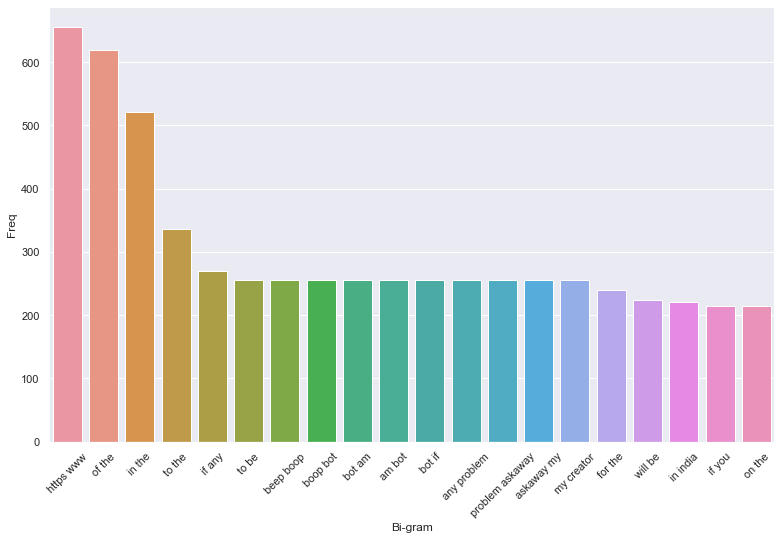

In [102]:
def get_top_n2_words(arr, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(arr)
    bag_of_words = vec1.transform(arr)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(arr, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
#print(top2_df)

#The barplot of the bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)
plt.show()

**Tri-grams**

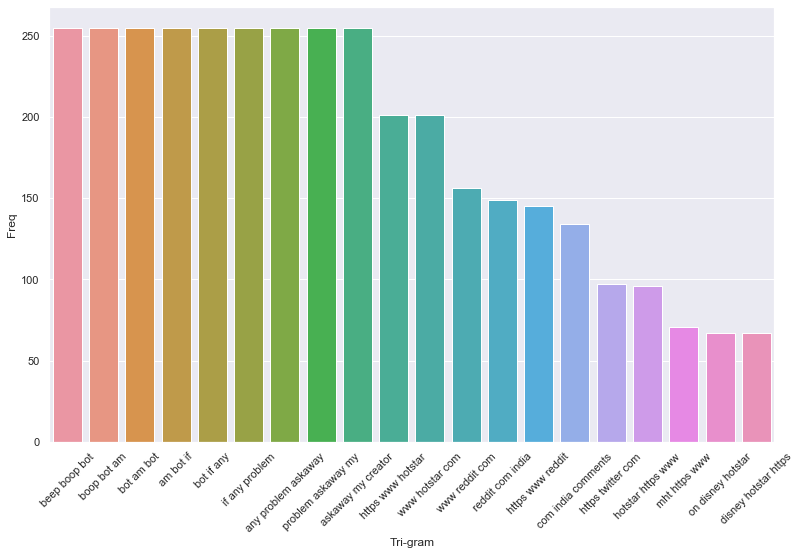

In [103]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(arr)
    bag_of_words = vec1.transform(arr)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(arr, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
#print(top3_df)

#The barplot
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)
plt.show()

In [104]:
## Now exporting the cleaned data for modeling

df.to_csv("data/processed.csv", index = False)